In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%run dataloader.ipynb

In [3]:
batch_size=2600
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)

In [4]:
gpu_id = 'cuda:7'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [5]:
# rnn
class RNN(torch.nn.Module):

    def __init__(self, input_dim_speech, input_dim_visual, hidden_layer_size) -> None:
        super().__init__()

        self.speech_rnn = torch.nn.LSTM(input_dim_speech, hidden_layer_size, batch_first=True, num_layers=2, dropout=0.2)
        self.visual_rnn = torch.nn.LSTM(input_dim_visual, hidden_layer_size, batch_first=True, num_layers=2, dropout=0.2)
        self.dropout = torch.nn.Dropout(0.2)
        self.linear = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x_speech, x_visual, text_lens):
        batch_size = x_speech.shape[0]

        interm_states_speech, _ = self.speech_rnn(x_speech)
        interm_states_visual, _ = self.visual_rnn(x_visual)

        final_state_speech = interm_states_speech[torch.arange(batch_size), text_lens - 1, :]
        final_state_visual = interm_states_visual[torch.arange(batch_size), text_lens - 1, :]

        stacked = torch.stack(( 
            final_state_speech,
            final_state_visual
            ), dim=1)
        pooled = torch.max(stacked, dim=1)[0]
        h = self.dropout(pooled)
        return self.linear(h)

step error


/tmp/ipykernel_3371341/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3371341/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3371341/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

1 0.6914410591125488
dev error:  0.6927116513252258
2 0.6890565752983093
dev error:  0.6919856667518616
3 0.6873369812965393
dev error:  0.6915640830993652
4 0.6850153803825378
dev error:  0.6914364099502563
5 0.6859064102172852
dev error:  0.6910865306854248
6 0.6797693967819214
dev error:  0.690570056438446
7 0.6745198965072632
dev error:  0.6909758448600769
8 0.6787141561508179
dev error:  0.6917362809181213
9 0.6742421388626099
dev error:  0.6919545531272888
10 0.672218918800354
dev error:  0.6941254734992981
11 0.6778287291526794
dev error:  0.6947963237762451
12 0.6745829582214355
dev error:  0.697641909122467
13 0.6688103079795837
dev error:  0.6938995718955994
14 0.6696134805679321
dev error:  0.6952379941940308
15 0.6686820387840271
dev error:  0.6932528018951416
16 0.6758540272712708
dev error:  0.6944863200187683


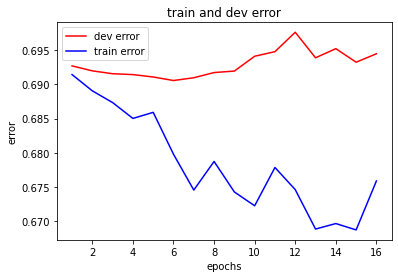

best model after 6 epochs with dev set error 0.690570056438446


In [6]:
# input features
###
idxs_speech = torch.arange(300, 381) # speech, 81
idxs_visual = torch.arange(381, 752) # visual, 371

device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
model = RNN(input_dim_speech=81, input_dim_visual=371, hidden_layer_size=256)
model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.002)
epochs = 100
patience = 10

print('step', 'error')
dev_errors = []
best_dev_error = np.inf
errors = []
num_bad_epochs = 0
num_epochs = 0
best_epoch = 0
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        optimiser.zero_grad()
        output = model(x_p[:, :, idxs_speech], x_p[:, :, idxs_visual], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        model.eval()
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0):
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            dev_output = model(x_p[:, :, idxs_speech], x_p[:, :, idxs_visual], x_p_len)
            dev_error = torch.nn.functional.binary_cross_entropy_with_logits(dev_output, y)
        dev_errors.append(float(dev_error))
        print('dev error: ', float(dev_error))

    if dev_error < best_dev_error:
        num_bad_epochs = 0
        best_dev_error = dev_error
        best_epoch = epoch
        torch.save(model, 'punchline_net_speech-visual.pth')
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            num_epochs = epoch
            break

plt.plot(range(1, num_epochs+1), dev_errors, 'r', label='dev error')
plt.plot(range(1, num_epochs+1), errors, 'b', label='train error')
plt.title('train and dev error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()
plt.show()

print('best model after {} epochs with dev set error {}'.format(best_epoch, best_dev_error))
model = torch.load('punchline_net_speech-visual.pth')

In [9]:
hid_humor_t = {}
hid_humor_f = {}
hid_nonhumor_t = {}
hid_nonhumor_f = {}

with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid, x_p_len=map(lambda x: x.to(device), batch)
        output = model(x_p[:, :, idxs_speech], x_p[:, :, idxs_visual], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        scaled_outputs = torch.sigmoid(output)
        predictions = (scaled_outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
        for j, id in enumerate(hid.detach().tolist()):
            if predictions[j] == 1 and y[j] == 1:
                hid_humor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 1 and y[j] == 0:
                hid_humor_f[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 0:
                hid_nonhumor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 1:
                hid_nonhumor_f[id] = scaled_outputs[j].detach().tolist()[0]
            else:
                print('something is wrong')
    acc = matches / total
    print('test error: ', float(error))
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_3371341/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3371341/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3371341/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

test error:  0.6797508001327515
test accuracy: 58.06%


In [10]:
print(len(hid_humor_t))
print(len(hid_nonhumor_t))
print(len(hid_humor_f))
print(len(hid_nonhumor_f))

language_sdk=load_pickle("language_sdk.pkl")

sorted_humor_t = {k: v for k, v in sorted(hid_humor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_t = {k: v for k, v in sorted(hid_nonhumor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_humor_f = {k: v for k, v in sorted(hid_humor_f.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_f = {k: v for k, v in sorted(hid_nonhumor_f.items(), key=lambda item: item[1], reverse=True)}

for hid, output in list(sorted_humor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_humor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])

244
325
165
246
the good news is i married her the next year
i'm going to guide you into the car
but it turns out that the key social identifier is how much you're going to talk in the car
i haven't come to the best part
they probably should have marketed this as some of the guardians of the galaxy

i would have told you myself that i was the last person on earth who would stay with a man who beats me but in fact i was a very typical victim because of my age
it's a load of nonsense
another called twister and so on and so on
we set up a whole er
it's part of the answer

participants who felt rich took two times as much candy as participants who felt poor
it just so happens that stewart's brand of funny doesn't work unless the facts are true
has started a dark net site
now comedy travels along a distinct wavelength from other forms of language
the second law is a law of humility if you like

i was going to use you but i decided i might want to come back another year
and she had just put 